##### This is check 1 of my calibration code. We reduce the time window, where the quadratic drag model and the free fall model have better agreement. 

## Part 2: Calibration

This is Alan's version of [Surmise's Example 2](https://nbviewer.jupyter.org/github/surmising/surmise/blob/master/examples/Example2/Example2_nb.ipynb).

Here, we will expand on my version on Example 1 which pertained the emulation of two ball drop models. 

We first import the required libraries.

In [2]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt 
from emulation import emulator
from calibration import calibrator

We collect data at the same heights done in Surmise's Example 2: 25 and 50.

Again $x = (t, h_{0})$.

In [3]:
x = np.array([[ 0.05, 25. ],
              [ 0.1, 25. ],
              [ 0.15, 25. ],
              [ 0.2, 25. ],
              [ 0.25, 25. ],
              [ 0.3, 25. ],
              [ 0.35, 25. ],
              [ 0.4, 25. ],
              [ 0.45, 25. ],
              [ 0.5, 25. ],
              [ 0.55, 25. ],
              [ 0.6, 25. ],
              [ 0.65, 25. ],
              [ 0.7, 25. ],
              [ 0.75, 25. ],
              [ 0.8, 25. ],
              [ 0.85, 25. ],
              [ 0.9, 25. ],
              [ 0.95, 25. ],
              [ 1.0, 25. ],
              [ 1.05, 25. ],
              [ 1.1, 25. ],
              [ 1.15, 25. ],
              [ 1.2, 25. ],
              [ 1.25, 25. ],
              [ 1.3, 25. ],
              [ 1.35, 25. ],
              [ 1.4, 25. ],
              [ 1.45, 25. ],
              [ 1.5, 25. ],
              [ 0.05, 50. ],
              [ 0.1, 50. ],
              [ 0.15, 50. ],
              [ 0.2, 50. ],
              [ 0.25, 50. ],
              [ 0.3, 50. ],
              [ 0.35, 50. ],
              [ 0.4, 50. ],
              [ 0.45, 50. ],
              [ 0.5, 50. ],
              [ 0.55, 50. ],
              [ 0.6, 50. ],
              [ 0.65, 50. ],
              [ 0.7, 50. ],
              [ 0.75, 50. ],
              [ 0.8, 50. ],
              [ 0.85, 50. ],
              [ 0.9, 50. ],
              [ 0.95, 50. ],
              [ 1.0, 50. ],
              [ 1.05, 50. ],
              [ 1.1, 50. ],
              [ 1.15, 50. ],
              [ 1.2, 50. ],
              [ 1.25, 50. ],
              [ 1.3, 50. ],
              [ 1.35, 50. ],
              [ 1.4, 50. ],
              [ 1.45, 50. ],
              [ 1.5, 50. ], ]).astype('object')
xv = x.astype('float')

Here, $\theta = \gamma$ and $\phi = (m, D)$.

In [4]:
def balldroptrue(x, theta, phi):
    def logcosh(x):
        # preventing crashing
        s = np.sign(x) * x
        p = np.exp(-2 * s)
        return s + np.log1p(p) - np.log(2)
    t = x[:, 0]
    h0 = x[:, 1]
    m = phi[0]
    D = phi[1]
    gamma = theta
    g = 9.81
    c = gamma*(D**2)
    vter = np.sqrt(m * (g/c))
    y = h0 - (vter ** 2) / g * logcosh(g * t / vter)
    return y

In [5]:
#Parameters of the ball (m and D) and drag coefficient (gamma)
m = 1
D = 1
gamma = 0.5

# variance for the observations in 'y' below
obsvar = 4*np.ones(x.shape[0])

#observations at each row of 'x'
phi = np.array([m, D])
y = balldroptrue(xv, gamma, phi)

print(np.shape(y))

x[x[:,1] == 25, 1] = 'lowdrop'
x[x[:,1] == 50, 1] = 'highdrop'

(60,)


### Model Emulation

We recall the computer model experiments and prior distributions from Example 1.

In [6]:
def balldropmodel_grav(x, theta):
    f = np.zeros((theta.shape[0],x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1]
        g = theta[k]
        f[k, :] = h0 - (g / 2) * (t ** 2)
    return f.T

def balldropmodel_quad(x, theta, phi):
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1]
        g = theta[k, 0]
        gamma = theta[:, 1]
        m = phi[:, 0]
        D = phi[:, 1]
        c = gamma[k]*(D[k]**2)
        vter = np.sqrt(m[k] * (g/c))
        
        if gamma[k] > 0.0 :
            f[k, :] = h0 - ((vter**2)/g)*np.log(np.cosh(g*t/vter))
        else :
            f[k, :] = balldropmodel_grav(x, theta)
    return f.T

class priorphys_grav:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return (sps.gamma.logpdf(theta[:, 0], 2, 0, 4.9)).reshape((len(theta), 1))
    
    def rnd(n):
        return np.reshape(sps.gamma.rvs(2, 0, 4.9, size=n), (-1, 1))  # gravity
    
class priorphys_quad:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        #print(theta)
        return (sps.gamma.logpdf(theta[:, 0], 2, 0, 4.9) + #gravity
                sps.gamma.logpdf(theta[:, 1], 10, 0, 0.05)).reshape((len(theta), 1))   # gamma


    def rnd(n):
        return np.vstack((sps.gamma.rvs(2, 0, 4.9, size=n),  # gravity
                          sps.gamma.rvs(10, 0, 0.05, size=n))).T # gamma

Now we build an emulator using PCGP to predict the computer model output:

In [7]:
# the time vector of interest
tvec = np.concatenate((np.arange(0.05, 1.55, 0.05), np.arange(0.05, 1.55, 0.05))) 

# the drop heights vector of interest
hvec = np.concatenate((25 * np.ones(30), 50 * np.ones(30)))  

# the input of interest
xtot = (np.round(np.vstack((tvec, hvec)).T,3)).astype('object')
xtotv = xtot.astype('float')
xtot[xtot[:,1] == 25, 1] = 'lowdrop'
xtot[xtot[:,1] == 50, 1] = 'highdrop'

# draw 50 random parameters from the prior
theta_grav = priorphys_grav.rnd(50) 

# draw 50 random parameters from the prior
theta_quad = priorphys_quad.rnd(50)  

# Draw a list of fixed parameters
phi = np.vstack(( m * np.ones(50), D * np.ones(50))).T

# create a computer experiment to build an emulator for the linear simulation
f_grav = balldropmodel_grav(xv, theta_grav)

# create a computer experiment to build an emulator for the gravity simulation
f_quad = balldropmodel_quad(xv, theta_quad, phi)  

# build an emulator for the gravity simulation
emu_grav = emulator(x=x, theta=theta_grav, f=f_grav, method='PCGP')  

# build an emulator for the linear simulation
emu_quad = emulator(x=x, theta=theta_quad, f=f_quad, method='PCGP')

## Model Calibration

In [8]:
def plot_theta(cal, whichtheta):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    cal_theta = cal.theta.rnd(1000) 
    axs[0].plot(cal_theta[:, whichtheta])
    axs[1].boxplot(cal_theta[:, whichtheta])
    axs[2].hist(cal_theta[:, whichtheta])
    plt.show()
    
def plot_preds(cal, axs):
    # getting a prediction object   
    post = cal.predict(x)
    rndm_m = post.rnd(s = 1000)
    for k in (25,50):
        inds = np.where(xv[:,1] == k)[0]
        upper = np.percentile(rndm_m[:, inds], 97.5, axis = 0)
        lower = np.percentile(rndm_m[:, inds], 2.5, axis = 0)
        axs.fill_between(xv[inds,0], lower, upper, color = 'grey', alpha=0.25)
        axs.plot(xv[inds, 0], y[inds], 'ro', markersize = 5, color='red')
    return(axs)

def plot_contour(cal, draws):

    cal_theta = cal.theta.rnd(draws) 
    
    # Creating dataset
    x = np.array(cal_theta[:, 0])
    y = np.array(cal_theta[:, 1])

    # Creating bins
    x_min = np.min(x)
    x_max = np.max(x)

    y_min = np.min(y)
    y_max = np.max(y)

    x_bins = np.linspace(x_min, x_max, 10)
    y_bins = np.linspace(y_min, y_max, 10)

    fig, ax = plt.subplots(figsize =(5, 3))
    # Creating plot
    plt.hist2d(x, y, bins =[x_bins, y_bins], cmap = plt.cm.nipy_spectral)
    plt.title("2D Gaussian Heat Plot")

    # Adding color bar
    plt.colorbar()

    ax.set_xlabel('Gauss1') 
    ax.set_ylabel('Gauss2') 

    # show plot
    plt.tight_layout() 
    plt.show()

In [9]:
cal_grav_1 = calibrator(emu=emu_grav,
                        y=y,
                        x=x,
                        thetaprior=priorphys_grav, 
                        method='directbayes',
                        yvar=obsvar, 
                        args={'theta0': np.array([[9.8]]), 
                              'numsamp': 1000, 
                              'stepType': 'normal', 
                              'stepParam': np.array([1])})

In [10]:
cal_grav_2 = calibrator(emu=emu_grav,
                        y=y,
                        x=x,
                        thetaprior=priorphys_grav, 
                        method='directbayes',
                        yvar=obsvar, 
                        args={'sampler': 'LMC',
                              'theta0': priorphys_grav.rnd(1000)}) 

In [11]:
cal_grav_3 = calibrator(emu=emu_grav,
                        y=y,
                        x=x,
                        thetaprior=priorphys_grav, 
                        method='directbayeswoodbury',
                        yvar=obsvar)

Plot posterior distributions for $g$:

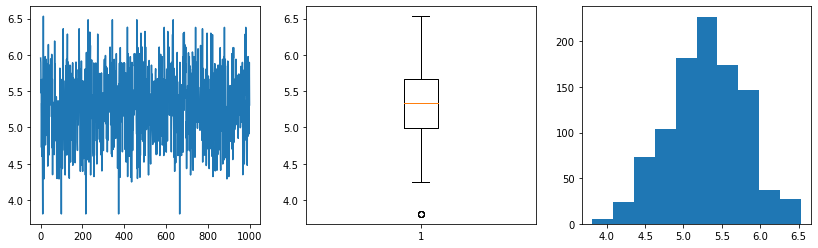

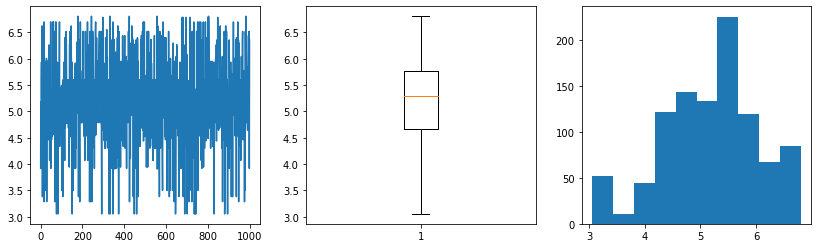

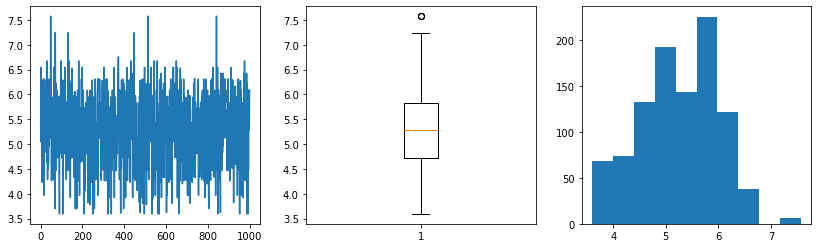

In [12]:
plot_theta(cal_grav_1, 0)
plot_theta(cal_grav_2, 0)
plot_theta(cal_grav_3, 0)

Now, we plot the predictions from the ball drop with no drag (95% confidence intervals) along with data points:

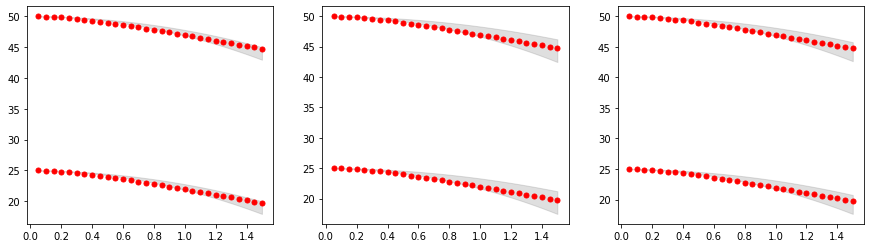

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0] = plot_preds(cal_grav_1, axs[0])
axs[1] = plot_preds(cal_grav_2, axs[1])
axs[2] = plot_preds(cal_grav_3, axs[2])
plt.show()

### Calibrators of Model 2

In [14]:
cal_quad_1 = calibrator(emu=emu_quad,
                       y=y,
                       x=x,
                       thetaprior=priorphys_quad, 
                       method='directbayes',
                       yvar=obsvar, 
                       args={'theta0': priorphys_quad.rnd(1), 
                             'numsamp': 1000, 
                             'stepType': 'normal', 
                            #'stepParam': np.array([0.1, 1, 0.5])}) # What are these arguments?
                            })

In [15]:
cal_quad_2 = calibrator(emu=emu_quad,
                       y=y,
                       x=x,
                       thetaprior=priorphys_quad, 
                       method='directbayes',
                       yvar=obsvar, 
                       args={'sampler': 'LMC',
                             'theta0': priorphys_quad.rnd(100)})  

In [16]:
cal_quad_3 = calibrator(emu=emu_quad,
                       y=y,
                       x=x,
                       thetaprior=priorphys_quad, 
                       method='directbayeswoodbury',
                       yvar=obsvar)  

Plot posterior distributions for $g$:

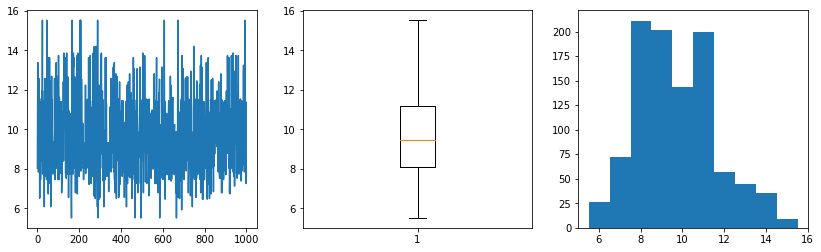

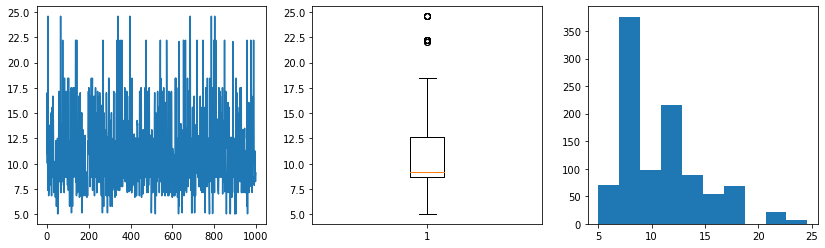

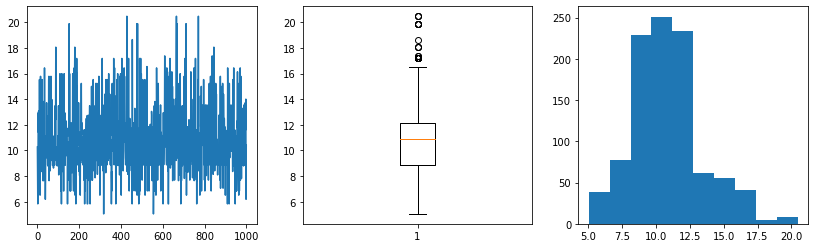

In [17]:
# visualize posterior draws for the calibration parameter
plot_theta(cal_quad_1, 0)
plot_theta(cal_quad_2, 0)
plot_theta(cal_quad_3, 0)

Plot posterior distributions for $\gamma$:

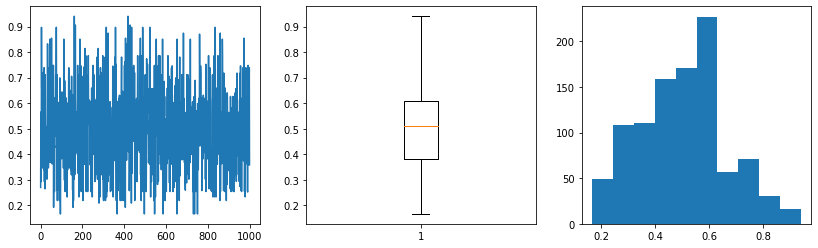

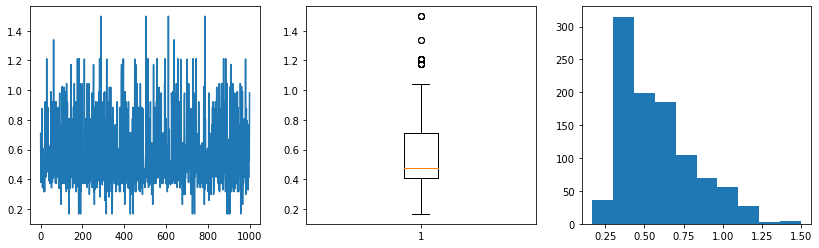

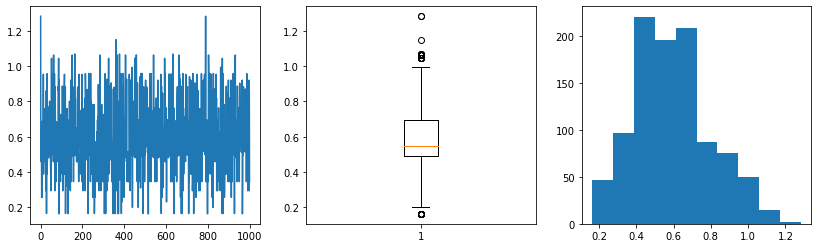

In [18]:
plot_theta(cal_quad_1, 1)
plot_theta(cal_quad_2, 1)
plot_theta(cal_quad_3, 1)

Here, we will plot 2d heat maps corresponding to the histograms previously obtained for $\theta = (g, \gamma)$.  

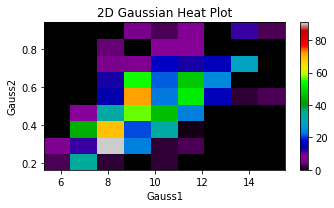

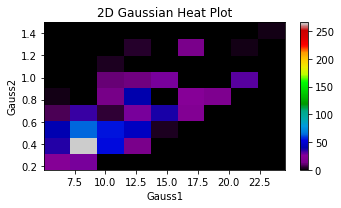

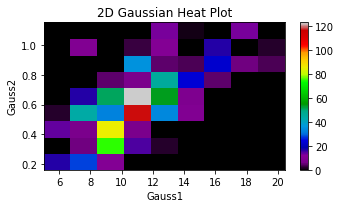

In [19]:
plot_contour(cal_quad_1, 1000)
plot_contour(cal_quad_2, 1000)
plot_contour(cal_quad_3, 1000)

Now I will try to create a 2D Gaussian heat plot to see if my figure generator (plot_contour) is correct. 

In [20]:
def plot_contour_norm(mu, sigma, draws):

    # Creating dataset
    x = sps.norm.rvs(mu, sigma, draws)
    y = sps.norm.rvs(mu, sigma, draws)

    # Creating bins
    x_min = np.min(x)
    x_max = np.max(x)

    y_min = np.min(y)
    y_max = np.max(y)

    x_bins = np.linspace(x_min, x_max, 50)
    y_bins = np.linspace(y_min, y_max, 50)

    fig, ax = plt.subplots(figsize =(10, 7))
    # Creating plot
    plt.hist2d(x, y, bins =[x_bins, y_bins], cmap = plt.cm.nipy_spectral)
    plt.title("2D Gaussian Heat Plot")

    # Adding color bar
    plt.colorbar()

    ax.set_xlabel('Gauss1') 
    ax.set_ylabel('Gauss2') 

    # show plot
    plt.tight_layout() 
    plt.show()

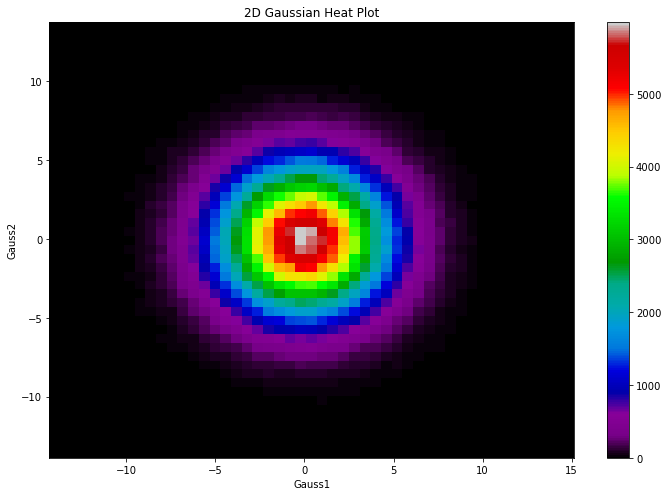

In [21]:
plot_contour_norm(0, 3, 1000000)

Now, we plot the predictions from the ball drop with quadratic drag (95% confidence intervals) along with data points. 

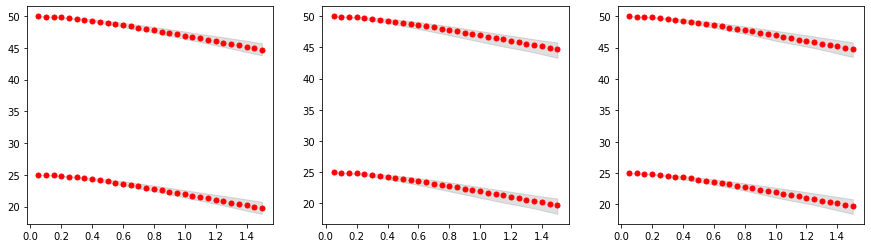

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0] = plot_preds(cal_quad_1, axs[0])
axs[1] = plot_preds(cal_quad_2, axs[1])
axs[2] = plot_preds(cal_quad_3, axs[2])
plt.show()

## These were bad attempts to get contour maps: 

In [23]:
# def plot_contour(cal, draws):
#     """
#     Make a plot
#     """
    
#     cal_theta = cal.theta.rnd(draws) 
#    # print(np.array([cal_theta[:, 1]]).T @ np.array([cal_theta[:, 0]]))
    
    
#     x_max = np.max([cal_theta[:, 0]]); y_max = np.max([cal_theta[:, 1]])
#     x_pts = np.arange(0, x_max, x_max / draws)  # You may want to adjust the 
#     y_pts = np.arange(0, y_max, y_max /draws)  #  density of points used.
#     x_grid, y_grid = np.meshgrid(x_pts, y_pts)  
    
#     Z_grid = np.array([cal_theta[:, 1]]).T @ np.array([cal_theta[:, 0]]) # Still needs work here
# #    Z_grid = np.exp(Z_grid - np.max(Z_grid))  # normalize the peak to be 1
# #    print(Z_grid)
    
#     Z_max = np.max(Z_grid)
#  #   print(x_max, y_max, Z_max)
    
#     fig, axes = plt.subplots(1, 2, figsize=(12,5))

#     contour_levels = [Z_max * 0.2, Z_max * 0.4, Z_max * 0.6, Z_max * 0.8, Z_max]
#     axes[0].contour(x_grid, y_grid, Z_grid, levels=contour_levels)
#     axes[0].set_xlim(0, 0.9 * x_max)
#     axes[0].set_ylim(0, 0.9 * y_max)
#     axes[0].set_xlabel(r'$gravity$')
#     axes[0].set_ylabel(r'$drag$')
#     axes[0].set_title('Contour plot with levels 0.2, 0.4, 0.6, 0.8, 1.0')
        
#     axes[1].contourf(x_grid, y_grid, Z_grid, levels=contour_levels, cmap='jet')
#     axes[1].set_xlim(0, 0.9 * x_max)
#     axes[1].set_ylim(0, 0.9 * y_max)
#     axes[1].set_xlabel(r'$gravity$')
#     axes[1].set_ylabel(r'$drag$')
#     axes[1].set_title('Color contour plot with contourf')

In [24]:
# plot_contour(cal_quad_1, 10)
# plot_contour(cal_quad_2, 10)
# plot_contour(cal_quad_3, 10)